In [207]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [190]:
csv_path = r"C:\Projects\Hackday\data\3390_Trafostation_2024-01-01_2024-09-11.csv"

df = pd.read_csv(csv_path, sep=";")
df["date_fmt"] = pd.to_datetime(df["Datum"], format="%d.%m.%Y %H:%M:%S %z")
df = df[df["Wert"] > 0]

C:\Users\LuuQ\AppData\Local\Temp\ipykernel_3356\3398962135.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["date_fmt"] = pd.to_datetime(df["Datum"], format="%d.%m.%Y %H:%M:%S %z")


In [ ]:
def process_data(df: pd.DataFrame):
    

In [202]:
window_size = 4 * 8
window_size_week = 4 * 24 * 14
df["moving_avg"] = df["Wert"].rolling(window=window_size_week).mean().fillna(1)
df["80_percentile"] = df[["Wert", "moving_avg"]].max(axis=1).rolling(window=window_size).quantile(0.75)
df["threshold"] = df[["moving_avg", "80_percentile"]].max(axis=1)
df["high_usage"] = df["Wert"] > df["threshold"]
df["high_usage"] = df["high_usage"].shift(1).fillna(value=False) & df["high_usage"].shift(-1).fillna(value=False)

def calc_diff_percentage(row):
    val = (row["Wert"] - row["threshold"])**2 / row["threshold"]
    if row["Wert"] < row["threshold"]:
        val = -val
    return val

df["diff_percentage"] = df.apply(lambda x: calc_diff_percentage(x), axis=1)

C:\Users\LuuQ\AppData\Local\Temp\ipykernel_3356\1535609669.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["high_usage"] = df["high_usage"].shift(1).fillna(value=False) & df["high_usage"].shift(-1).fillna(value=False)


In [203]:
df[["moving_avg", "80_percentile", "threshold", "diff_percentage"]]

,moving_avg,80_percentile,threshold,diff_percentage
0,1.000000,NaN,1.0,36252.160000
1,1.000000,NaN,1.0,36481.000000
2,1.000000,NaN,1.0,32256.160000
3,1.000000,NaN,1.0,37636.000000
4,1.000000,NaN,1.0,31612.840000
...,...,...,...,...
24417,70.195089,86.7,86.7,-39.472318
24418,70.170089,86.7,86.7,-11.444637
24419,70.152232,86.7,86.7,-7.151211
24420,70.137054,86.7,86.7,-10.174048


In [204]:
df_latest = df.tail(7* 4 * 24).copy()
df_latest = df_latest.reset_index(drop=True)

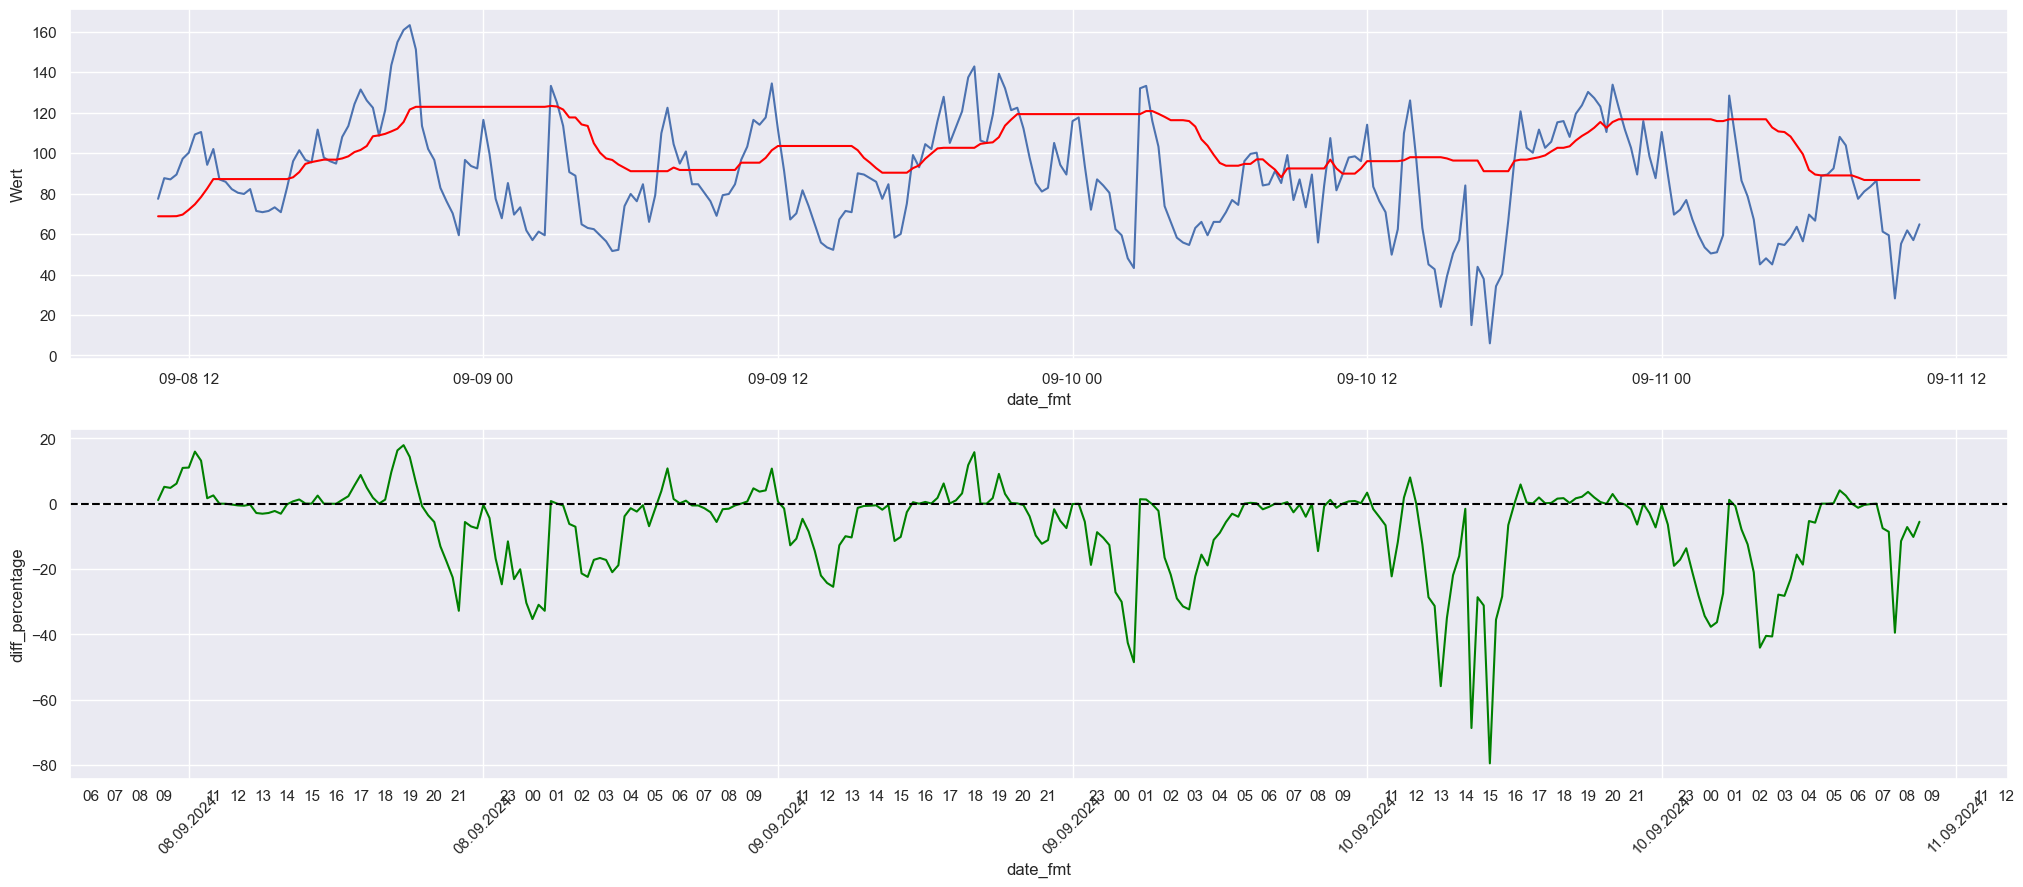

In [206]:
import matplotlib.dates as mdates

df_latest = df.tail(3 * 4 * 24).copy()

sns.set_theme(rc={"figure.figsize":(25,10)})

fig, axes = plt.subplots(2, 1)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m.%Y"))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%H"))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=1))
plt.xticks(rotation=45)
 
sns.lineplot(data=df_latest, x="date_fmt", y="Wert", ax=axes[0])
sns.lineplot(data=df_latest, x="date_fmt", y="threshold", color="red", ax=axes[0])

# plot diff_perf on secondary y-axis
sns.lineplot(data=df_latest, x="date_fmt", y="diff_percentage", ax=axes[1], color="green")
axes[1].axhline(y=0, color="black", linestyle="--")